In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group01\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group01\.qcodes\logs\240501-17724-qcodes.log


In [2]:
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')
microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.33s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.16s


0

## Background

Up to now, we have worked with pulse sequences that require us to use only one itteration per refference envelope due to the experiment length involved. This isn't always a requirement, so we can instead repeat large numbers of pulses under an envelope. This can be done on the PulseBlaster as shown below:

In [3]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D/ref_f                 #Reference time on.
T_ref_off = (1 - ref_D)/ref_f          #Reference time off.

#TODO: Change the laser frequency and duty cycle to see how this works.
laser_f = 2000                                   #Laser modulation frequency.
laser_D = 0.4                             #Laser modulation duty cycle.
T_laser_on = laser_D/laser_f                #Laser on time. 
T_laser_off = (1 - laser_D)/laser_f         #Laser off time.
N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

After setting your laser frequency and duty cycle above, notice that there is a for loop in our pulse which applies the pulse and delay N times. Run the cell below to see how this is structured.

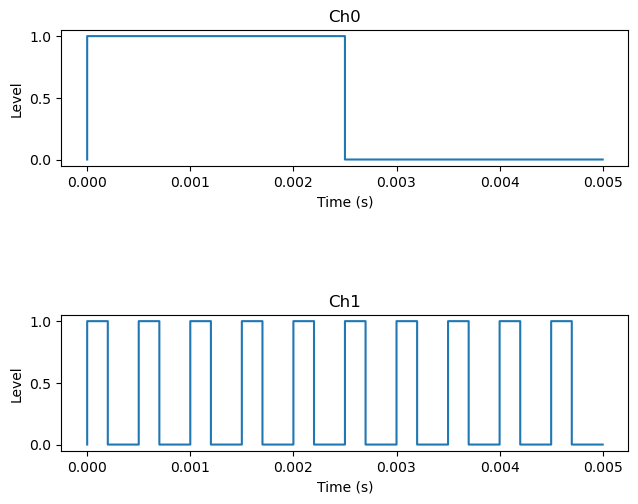

In [4]:
pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
)                                     #Define the new pulse sequence for channel 0.
pulse_blaster.ch1.pulse_sequence_buffer.set(
#TODO: Enter the laser pulse sequence.
    [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)]   
)                                     #Define the new pulse sequence for channel 1.
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.

## Optically Detected Magnetic Resonance

So far, we have used Channel 0 for reference signal and Channel 1 for the laser pulse sequence.  Now we would like to introduce microwave radiation to the sample.  The pulse sequence for this will be defined in Channel 2.

Set ch0 back to 200 Hz, and ch1 at 100 kHz pulsing continuously. For the microwave, we would like to create something similar to an inverted copy of the laser pulse sequence. Furthermore, Channel 2 must be modulated such that it follows the envelope of the reference signal in Channel 0. If you imagine that the reference (R), laser (L) and microwave (M) as digital signals, then M = R & (~L).

Your pulse sequence should look similar to Figure 4 in the paper. Create this sequence and use the pulse sequence plotting code so you can really see what the PulseBlaster is outputting.

### Q3. Explain why the microwave pulses must be modulated to follow the envelope of the reference signal?

In [5]:
#Use this to make a parameter out of anything!
MW = qc.ManualParameter('Frequency', unit='Hz')
LI_R = qc.ManualParameter('Amplitude', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "ODMR Sweep.db")
exp = load_or_create_experiment(
    experiment_name='ODMR Sweep',
    sample_name="no sample"
)

meas = Measurement(exp=exp, name='ODMR Sweep')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(LI_R)  # now register the dependent oone

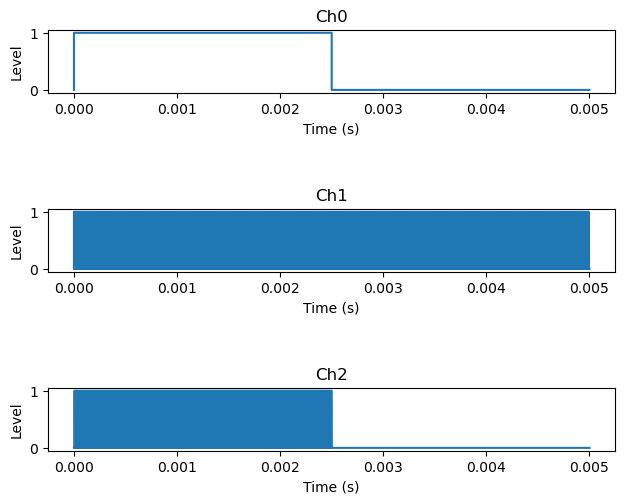

In [6]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                     #Reference duty cycle.
T_ref_on = ref_D/ref_f                 #Reference time on.
T_ref_off = (1 - ref_D)/ref_f  

#TODO: Specifiy these constants.
laser_f = 100e3                                   #Laser modulation frequency.
laser_D = 0.3                                        #Laser modulation duty cycle.
T_laser_on = laser_D/laser_f                #Laser on time. 
T_laser_off = (1 - laser_D)/laser_f         #Laser off time.
N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
mw_D = laser_D                               #Microwave modulation duty cycle.
T_mw_on = laser_D/laser_f                      #Microwave time on.
T_mw_off = (1 - laser_D)/laser_f                #Microwave time off.
T_mw_on = (1 - laser_D)/laser_f                       #Microwave time on.
T_mw_off =  laser_D/laser_f
N_mw_pulses = round(laser_f/(ref_f*2))             #Number of microwave pulses that can fit in the reference period.

tau = 1e-6

def ODMR():
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
        #TODO: Enter the laser pulse sequence.
        
    )                                     #Define the new pulse sequence for channel 0.
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)]   
        #TODO: Enter the laser pulse sequence.
        
    )                                     #Define the new pulse sequence for channel 1.
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        [[pulse(level=0, duration=T_mw_off+tau), pulse(level=1, duration= T_mw_on-2*tau),  pulse(level=0, duration=tau)] for i in range(0, N_mw_pulses)] +
        [pulse(level=0, duration=float(1/(2*ref_f)))]
        #TODO: Enter the laser pulse sequence.
    )                                     #Define the new pulse sequence for channel 2.

ODMR()
pulse_blaster.plot_channel_buffer() 
pulse_blaster.flush_channel_buffer()  #This function plots the newly defined pulse sequence.

In [7]:
pulse_blaster.stop()
microwave_src.output('OFF')
#Set the lock-in amplifier time constant and sensivity using the code segment below.
lock_in_amp.time_constant(1)#Your time constant here)
lock_in_amp.sensitivity(100e-12)

#Write period is the amount of time between start to finish of the experiment.
f_start = 2.86e9#2.6e9 #start time (in seconds)
num_steps = 150 #Number of steps
f_end = 2.89e9#2.99e9 #end time. The system will always round up to the nearest step size as to avoid missing a point if this is not divisible evenly. (in seconds)
freq_step = (f_end - f_start)/num_steps

Starting experimental run with id: 11. 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


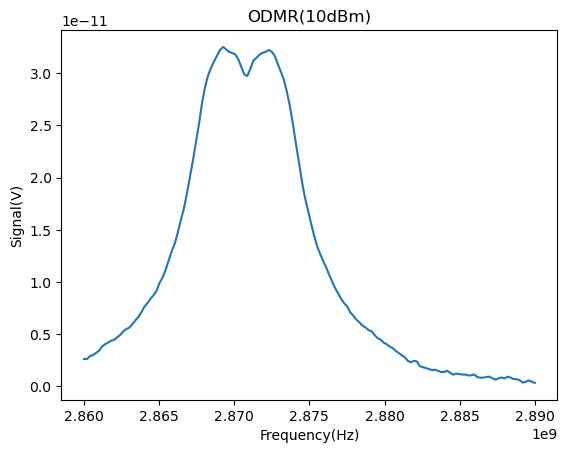

In [8]:
microwave_src.power(-10)#MW power here) #<= 15dBm
microwave_src.output('ON')
freqs = np.linspace(f_start, f_end, num_steps)
ODMR()
pulse_blaster.flush_channel_buffer()
with meas.run() as datasaver:
    for i in range(freqs.size): 
        #Reinitialize the pulse sequence with the new tau.
        #This is a good approach to initializing a new pulse sequence in a loop.
        microwave_src.frequency(freqs[i])
        print(i)

        pulse_blaster.flush_channel_buffer()
        #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
        if i == 0:
            sleep(10*lock_in_amp.time_constant())
        else:
            sleep(2*lock_in_amp.time_constant())
        ###############################
        #Specify the data being saved below
        datasaver.add_result((MW, freqs[i]),
                             (LI_R, lock_in_amp.R()))
        ###############################
    
    ODMR_data = datasaver.dataset
pulse_blaster.stop()

ODMR = ODMR_data.to_pandas_dataframe()
plt.plot(ODMR["Frequency"], ODMR["Amplitude"])
plt.xlabel('Frequency(Hz)')
plt.ylabel('Signal(V)')
plt.title(f'ODMR({10}dBm)')
plt.show()

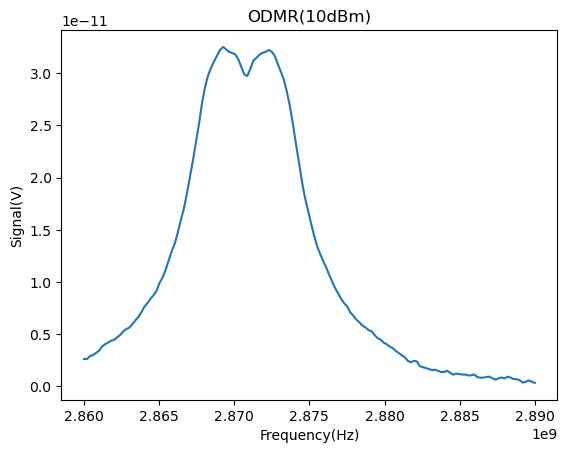

In [12]:

ODMR = ODMR_data.to_pandas_dataframe()
plt.plot(ODMR["Frequency"], ODMR["Amplitude"])
plt.xlabel('Frequency(Hz)')
plt.ylabel('Signal(V)')
plt.title(f'ODMR({10}dBm)')
plt.savefig(f"ODMR {10}dBm).png")
plt.show()

In [13]:
import pandas as pd

In [14]:
ODMR.to_csv("ODMR_data.csv")

Spend some time adjusting the parameters to answer the following questions:<br>
1. What is the effect of adjusting the microwave power? ($\leq 15$dBm)<br>
2. What effects do you notice as you narrow the frequency range towards the peak?